<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# импортируем библиотеку пандас
import pandas as pd 
# импортируем библиотеку для работы с датой и временем
import datetime as dt
# импорптируем библиотеку для работы с графиками
import matplotlib.pyplot as plt 
#Импортируем библиотеку сеаборн для построения множественных графиков.
import seaborn as sns
# импортируем библиотеку для расчета дисперсии и стандартного отклонения
import numpy as np 
# импортируем библиотеку для метрики
from sklearn.metrics import mean_squared_error, make_scorer
# импортируем библиотеку для разделение на выборки, кроссвалидацию 
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
# импортируем библиотеку для решающего дерева
from sklearn.tree import DecisionTreeRegressor
# импортируем библиотеку для линейной регрессии
from sklearn.linear_model import LinearRegression
# импортируем библиотеку для выявления трендов и сезонности
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
print(data.info())
display(data.head())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [3]:
# Проверим на хронологический порядок
data.index.is_monotonic

True

In [4]:
# Проведем их ресемплирование по 1 часу
data = data.resample('1H').sum()
print(data.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


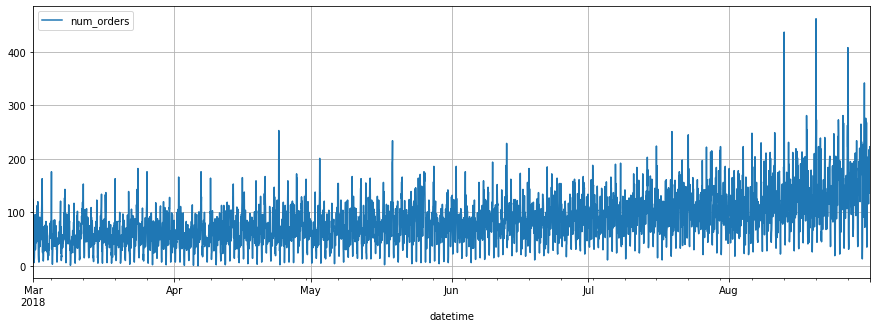

In [5]:
# Выведем график заказов
data.plot(label='Заказы такси', grid=True, figsize=(15, 5))

**Вывод**

У нас есть данные о количестве заказов такси каждые 10 минут. Данные без пропусков и расположны в хронологическом порядке. Мы их ресемплировали по 1 часу. Повышение количества заказов летом соответсвует летним отпускам. Далее мы проанализируем количество суммарных заказов за час.

## Анализ

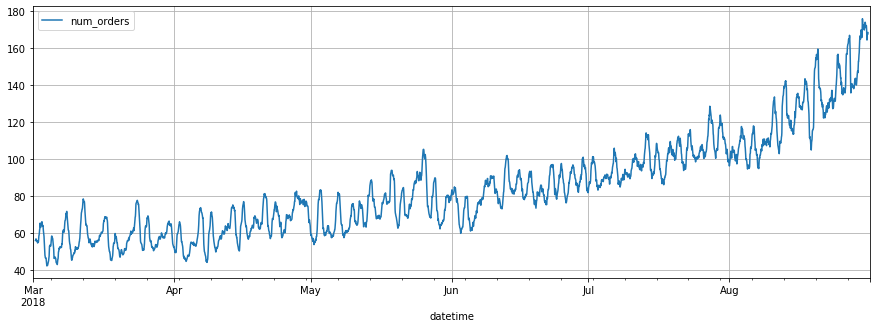

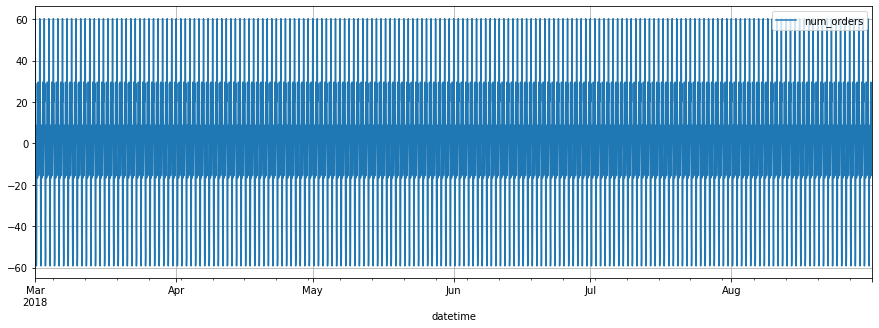

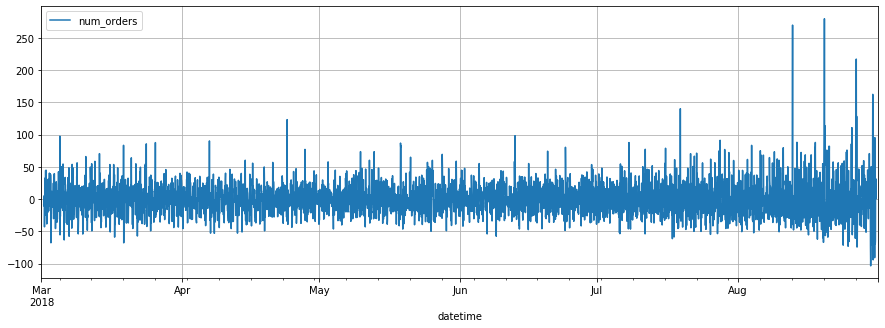

In [6]:
# Посмотрим закономерности
decomposed = seasonal_decompose(data) 
decomposed.trend.plot(label='Тренд', grid=True, figsize=(15, 5)) # тренд
decomposed.seasonal.plot(label='Сезонность', grid=True, figsize=(15, 5)) # сезонная составляющая
decomposed.resid.plot(label='Шум', grid=True, figsize=(15, 5)) # остаток декомпозиции


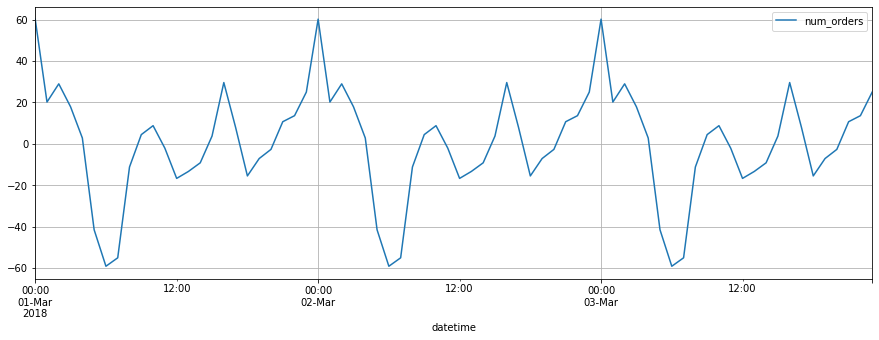

In [7]:
# Посмотрим сезонную составляющую за 3 дня
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(label='Сезонность', grid=True, figsize=(15, 5)) # сезонная составляющая

**Вывод**

В данных прослеживается тренд на увеличение количества заказов, но неизвестно связано ли оно с летним сезоном отпусков или с увеличением популярности. Однако мы точно можем сказать что существует суточная закономерность заказов, с просадкой заказов в утреннее время и увличением в ночное. Полночь является самым нагруженным временем для заказов. 

Даже без машинного обучения следует запускать в рейс с каждым днем все большее количество автомобилей, причем к полуночи их должно быть максимальное количество.

Однако построим предсказательную модель

## Обучение

Так как у нас есть данные только о количестве заказов и эти данные целиком являются целевым параметром. Требуется создать признаки.

In [8]:
# Функция для добавления признаков и разбиение данных на выборки
def make_features(df, max_lag, rolling_mean_size, target):
    df_new = df.copy()
    df_new['year'] = df_new.index.year
    df_new['month'] = df_new.index.month
    df_new['day'] = df_new.index.day
    df_new['dayofweek'] = df_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_new['lag_{}'.format(lag)] = df_new[target].shift(lag)

    df_new['rolling_mean'] = df_new[target].shift().rolling(rolling_mean_size).mean()
    
    # разобъем данные на тестовую и обучающую выборку
    # так как временной ряд, то нам нужны только последние значения
    train, test = train_test_split(df_new, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    features_train = train.drop([target], axis=1)
    target_train = train[target]

    features_test = test.drop([target], axis=1)
    target_test = test[target]
    
    return features_train, target_train, features_test, target_test

In [9]:
# Создадим функцию для метрики RMSE, которая явлется квадратным корнем из MSE
def rmse(real, predictions):
    return mean_squared_error(real, predictions) ** .5

In [10]:
# Создадим модель решающего дерева
dtr = DecisionTreeRegressor(random_state=12345)

# добавим кросс-валидацию
cv = TimeSeriesSplit(n_splits=6)

params_dtr = {
    'max_depth': range (7, 13, 1),
    'min_samples_leaf': range (10, 41, 4),
}

In [11]:
%%time
# Исследуем случайны лес
best_model_dt = None
best_result_dt = data['num_orders'].max()
best_rolling_mean_size_dt = 0
best_max_lag_dt = 0
rolling_mean_size_dt=[]
result_dt=[]
dt = pd.DataFrame()

for max_lag in range(24, 29, 1): # количество отстающих значений
    for rolling_mean_size in range(4, 10, 1):
        features_train, target_train, features_test, target_test = make_features(
            data, max_lag, rolling_mean_size, 'num_orders')
        model = GridSearchCV(dtr,
                        params_dtr,
                        cv=cv,
                        scoring=make_scorer(rmse, greater_is_better=False),
                        n_jobs=2
                        )
        model.fit(features_train, target_train) # обучим модель
        result = -model.best_score_ # качество модели
        rolling_mean_size_dt.append(rolling_mean_size)
        result_dt.append(result)
        if result < best_result_dt:
            best_model_dt = model
            best_result_dt = result
            best_rolling_mean_size_dt = rolling_mean_size
            best_max_lag_dt = max_lag
            best_features_test_dt = features_test
            best_target_test_dt = target_test
            
    grf=pd.DataFrame(data=result_dt, index=rolling_mean_size_dt)
    rolling_mean_size_dt=[]
    result_dt=[]
    if len(dt)==0:
        dt = grf
        dt = dt.rename(columns = {0 : max_lag})
    else:
        dt[max_lag] = grf
            
print('Параметры лучшей модели:', best_model_dt.best_params_) 
print("max_lag лучшей модели:", best_max_lag_dt) 
print("rolling_mean_size лучшей модели:", best_rolling_mean_size_dt) 
print("RMSE лучшей модели:", -best_model_dt.best_score_)
print('Время выполнения')

Параметры лучшей модели: {'max_depth': 9, 'min_samples_leaf': 34}
max_lag лучшей модели: 24
rolling_mean_size лучшей модели: 7
RMSE лучшей модели: 28.24228519609546
Время выполнения
CPU times: user 16.8 s, sys: 2.25 s, total: 19.1 s
Wall time: 3min 57s


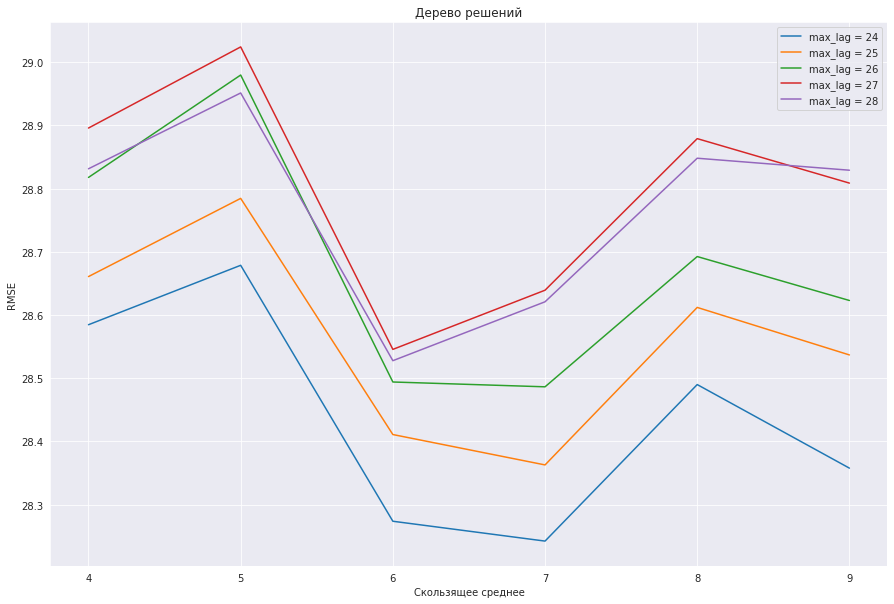

In [12]:
# Посмотрим на графике
plt.figure(figsize=(15,10))
sns.set_style('darkgrid')
for i in dt.columns:
    lbl = 'max_lag = ' + str(i)
    sns.lineplot(data = dt[i], label=lbl)
    
plt.legend()
plt.xlabel("Скользящее среднее")
plt.ylabel("RMSE")
plt.title("Дерево решений")
plt.show() 

In [13]:
# Создадим функцию кросс валидации для линейной регрессии
def performTimeSeriesCV(features_train, target_train, number_folds, model):
    
    k = int(np.floor(float(features_train.shape[0]) / number_folds))
 
    for i in range(2, number_folds + 1):
        split = float(i-1)/i

        features = features_train[:(k*i)]
        target = target_train[:(k*i)]

        index = int(np.floor(features.shape[0] * split))

        # folds used to train the model        
        features_trainFolds = features[:index]        
        target_trainFolds = target[:index]

        # fold used to test the model
        features_testFold = features[(index + 1):]
        target_testFold = target[(index + 1):]
        
        model.fit(features_trainFolds, target_trainFolds)
 
    return model

In [14]:
%%time
# Исследуем линейную регрессию
best_model_lr = None
best_result_lr = data['num_orders'].max()
best_max_lag_lr = 0
best_rolling_mean_size_lr = 0
rolling_mean_size_lr=[]
result_lr=[]
lr = pd.DataFrame()
for max_lag in range(10, 24, 2): # количество отстающих значений
    for rolling_mean_size in range(14, 30, 2):
        features_train, target_train, features_test, target_test = make_features(
            data, max_lag, rolling_mean_size, 'num_orders')
        model = performTimeSeriesCV(features_train, target_train, 6, LinearRegression())
        model.fit(features_train, target_train) # обучим модель
        result = rmse(target_train, model.predict(features_train)) # посчитаем качество модели
        rolling_mean_size_lr.append(rolling_mean_size)
        result_lr.append(result)
        if result < best_result_lr:
            best_model_lr = model
            best_result_lr = result
            best_rolling_mean_size_lr = rolling_mean_size
            best_max_lag_lr = max_lag
            best_features_test_lr = features_test
            best_target_test_lr = target_test
            
    grf=pd.DataFrame(data=result_lr, index=rolling_mean_size_lr)
    rolling_mean_size_lr=[]
    result_lr=[]
    if len(lr)==0:
        lr = grf
        lr = lr.rename(columns = {0 : max_lag})
    else:
        lr[max_lag] = grf

            
print("max_lag лучшей модели:", best_max_lag_lr) 
print("rolling_mean_size лучшей модели:", best_rolling_mean_size_lr) 
print("RMSE лучшей модели:", best_result_lr)
print('Время выполнения')

max_lag лучшей модели: 22
rolling_mean_size лучшей модели: 24
RMSE лучшей модели: 26.196646616185742
Время выполнения
CPU times: user 8.44 s, sys: 9.49 s, total: 17.9 s
Wall time: 17.9 s


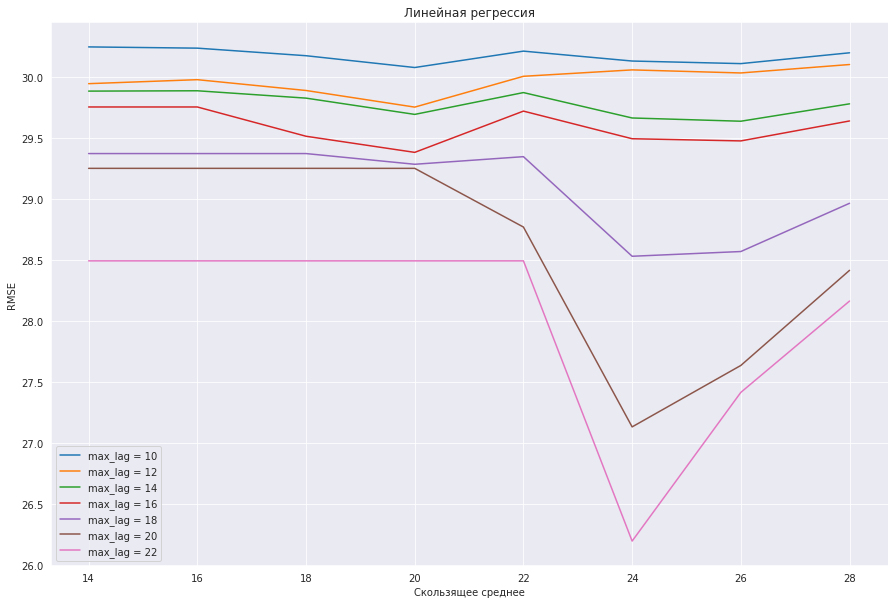

In [15]:
# Посмотрим на графике
plt.figure(figsize=(15,10))
sns.set_style('darkgrid')
for i in lr.columns:
    lbl = 'max_lag = ' + str(i)
    sns.lineplot(data = lr[i], label=lbl)
    
plt.legend()
plt.xlabel("Скользящее среднее")
plt.ylabel("RMSE")
plt.title("Линейная регрессия")
plt.show() 

**Вывод**

Мы протестировали различные модели с различными параметрами. При этом мы создали различные признаки для данных.

В итоге мы получили среднеквадратичную ошибку для дерева решений 28.2 автомобилей, а для линейной регрессии 26.2, что является хорошим результатом. По заданию RMSE не должно привышать 48. Следует эти модели проверить на тестовой выборке, а также проверить на адекватность.

## Тестирование

In [16]:
# Протестируем модели с их лучшими параметрами
print("RMSE дерева решений:", rmse(best_target_test_dt, best_model_dt.predict(best_features_test_dt)))
print("RMSE линейной регрессии:", rmse(best_target_test_lr, best_model_lr.predict(best_features_test_lr)))

RMSE дерева решений: 47.848879188029386
RMSE линейной регрессии: 44.53684409444748


In [17]:
# Проверим модели на адекватность
train, test = train_test_split(data, shuffle=False, test_size=0.1)
pred_median = np.ones(test.shape) * (train['num_orders'].median())
print("RMSE модели медианных значений:", rmse(test['num_orders'], pred_median))

RMSE модели медианных значений: 87.15277582981295


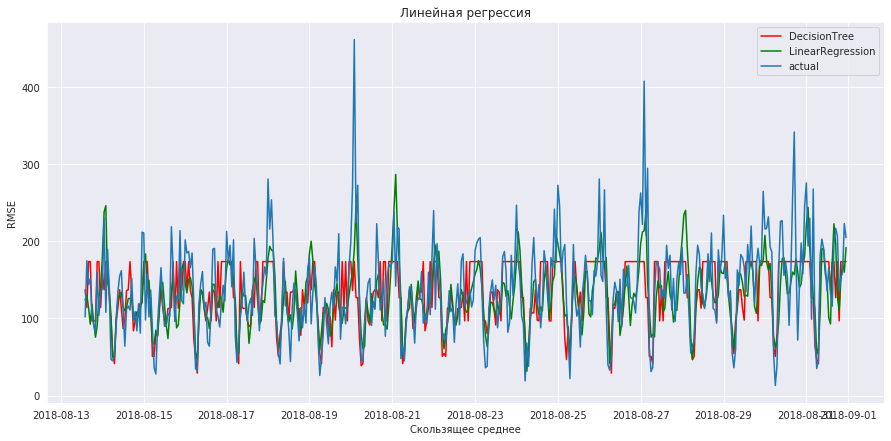

In [18]:
# Построим график предсказаний и реальных значений
prediction1 = best_model_dt.predict(best_features_test_dt)
prediction2 = best_model_lr.predict(best_features_test_lr)
plt.figure(figsize=(15, 7))
plt.plot(best_target_test_lr.index, prediction1, "r", label="DecisionTree")
plt.plot(best_target_test_lr.index, prediction2, "g", label="LinearRegression")
plt.plot(best_target_test_lr.index, best_target_test_lr.values, label="actual")
plt.legend()
plt.xlabel("Скользящее среднее")
plt.ylabel("RMSE")
plt.title("Линейная регрессия")
plt.grid(True)

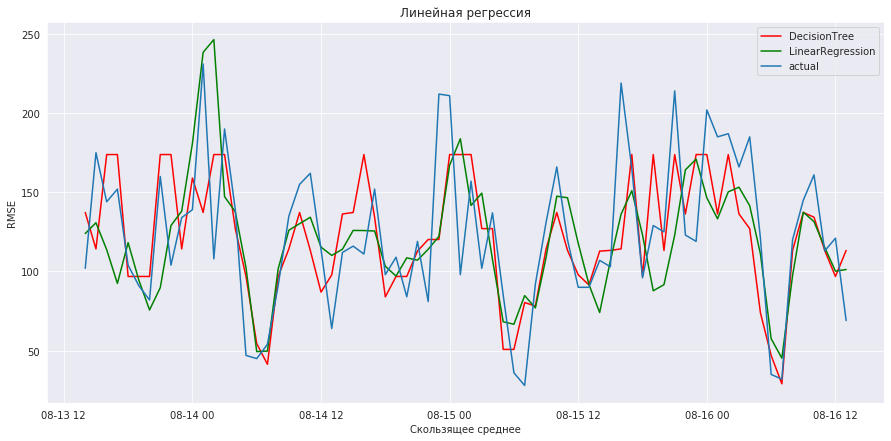

In [19]:
# Посмотрим прогноз на пару дней
n_day = 24*3
plt.figure(figsize=(15, 7))
plt.plot(best_target_test_lr.index[:n_day], prediction1[:n_day], "r", label="DecisionTree")
plt.plot(best_target_test_lr.index[:n_day], prediction2[:n_day], "g", label="LinearRegression")
plt.plot(best_target_test_lr.index[:n_day], best_target_test_lr.values[:n_day], label="actual")
plt.legend()
plt.xlabel("Скользящее среднее")
plt.ylabel("RMSE")
plt.title("Линейная регрессия")
plt.grid(True)

**Вывод**

                            RMSE(обучение)   RMSE(тест)
        Дерево решений         28.2            47.8
    Линейная регрессия         26.2            44.5
    Медианные значения           -             87.2

Обе модели проходят тест на адекватность и имеют RMSE значительно ниже модели на медианных значениях. Однако данные модли оказались переобучены и их метрика слегка ниже заданного значения в 48 единиц. Для работы по предсказыванию количества необходимых таксистов следует выбрать модль линейной регрессии, она обучается и работает быстрее, а также более точно предсказыват. Модель линейной регрессии с параметрами: 

    количество отстающих значний: 22
    Количество параметров для скользящего среднего: 24

## Вывод

В данном проекте нужно было создать модель предсказания количество заказов такси на час вперед. Данные представляют собой врменной ряд количества заказов такси в аэропортах каждые 10 минут с 1 марта 2018 по 31 августа 2018. Данные без пропусков в хронологическом порядке. Мы провели ресемплинг данных на каждый час. 

К сожалению выявить закономерность от времени года не удаться из-за данного временного промежутка, но можно заметить тренд на увеличения количества заказов, возможно это связано со временем года, летом люди чаще отдыхают/летают на самолетах, а возможно это связано с возрастанием популярности сервиса "Чётнкое такси". Мы можем выявить закономерность в заказах такси в течении дня, то есть с полуночи до утра идет снижение заказов, а вот потом увеличении.

Далее мы создали и протестировали несколько моделей с добавлением в данные новых признаков, отстающих значений и скользящее среднее для выявления моделями возможных закономерностей. Модели *дерево решений* и *линейная регрессия* оказались переобучены и на тестовой выборке показали результат слегка превосходящий порог в 48 единиц. Так *дерево решений* с **RMSE = 47.8**, а модель *линейной регрессии* показала **RMSE = 44.5**.

Модель линейной регрессии можно запускать в работу по предсказыванию. С добавлением следующих признаков в данные:
    
    Количество отстающих значений = 22
    Количество параметров для скользящего среднего = 24